# Parametric Sensetivity 

+ $s$ - selection strength
+ RRS - reletive reproductive success
+ k - compensation ratio
+ $R_{im}$ - Immigration rate 
+ life hsitry parameters
+ Selection before or after immigraiton 
+ T - length of program 

In [1]:
include("AgeStructuredModels.jl")
include("DemographicParameters.jl")
include("AgeTraitStructuredModels.jl")
include("StockRecruitCurves.jl")
using Plots
theme(:wong2)

# initialize demographic model - paramters loaded from DemographicParameters.jl 
# see tests in "TestDemographicParametersparams.ipynb"
mod1 = AgeStructuredModels.init(150,DemographicParameters.Smyth_2016_sr,DemographicParameters.Smyth_2016_survival,
    DemographicParameters.Smyth_16_F_vec)

Rstar = AgeStructuredModels.compute_Rstar(mod1)
k = 1.5


# set base genetic paramters
Vle = 1.0
θ = 0.0
s = 0.1
min = -5
max = 20 
Δz = 0.15

# set base paramters for propogated individuals 
μ_im = 5.0
R_im = 1.0 * Rstar  # 50% natrual recrutment 

# initialize coupled genetic-demogrpahic model 
pop = AgeTraitStructuredModels.init(mod1,Vle, θ, s, min, max, Δz)
StockRecruitCurves.update_BevetonHolt_k!(pop.ageStructure.SRCurve, k)
im = AgeTraitStructuredModels.init_imigrants(pop, R_im, μ_im)
print(" ")

# Test trait grid

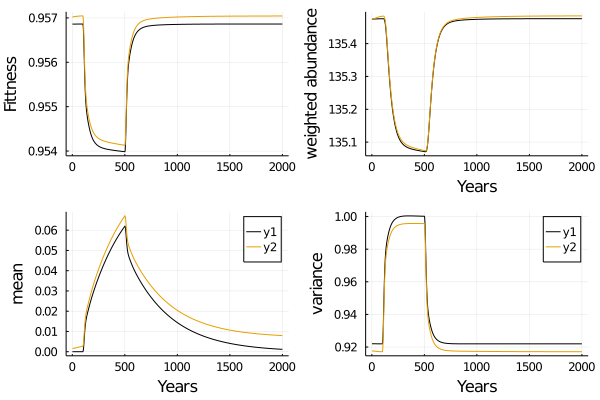

In [2]:
theme(:wong2)
s = 0.1

μ_im = 8.0

pop = AgeTraitStructuredModels.init(DemographicParameters.mod_Wood_2007_1,Vle, θ, s, min, max, Δz)
im = AgeTraitStructuredModels.init_imigrants(pop, R_im, μ_im)

pop2 = AgeTraitStructuredModels.init(DemographicParameters.mod_Wood_2007_1,Vle, θ, s, -3.0, μ_im + 3.0, 0.5)
im2 = AgeTraitStructuredModels.init_imigrants(pop2, R_im, μ_im)
AgeTraitStructuredModels.reset!(pop2,s)

T = 2000
t_stock = 100
T_stock = 500
fittness = zeros(T)
recruitment = zeros(T)
SSB = zeros(T)
mu, sigma = zeros(T), zeros(T)

fittness2 = zeros(T)
recruitment2 = zeros(T)
SSB2 = zeros(T)
mu2, sigma2 = zeros(T), zeros(T)
F = 0.1

for t in 1:T
    if t < t_stock
        AgeTraitStructuredModels.time_step_DIS!(pop)
        recruitment[t] = AgeTraitStructuredModels.recruitment(pop)
        
        AgeTraitStructuredModels.time_step_DIS!(pop2)
        recruitment2[t] = AgeTraitStructuredModels.recruitment(pop2)
    elseif t < T_stock
        pop.abundanceH .= exp(-1*F).*pop.abundanceH
        AgeTraitStructuredModels.time_step_DIS!(pop,im)
        recruitment[t] = AgeTraitStructuredModels.recruitment(pop) - im.N
        
        pop2.abundanceH .= exp(-1*F).*pop2.abundanceH
        AgeTraitStructuredModels.time_step_DIS!(pop2,im2)
        recruitment2[t] = AgeTraitStructuredModels.recruitment(pop2) - im.N
    else
        pop.abundanceH .= exp(-1*F).*pop.abundanceH
        AgeTraitStructuredModels.time_step_DIS!(pop)
        recruitment[t] = AgeTraitStructuredModels.recruitment(pop)
        
        pop2.abundanceH .= exp(-1*F).*pop2.abundanceH
        AgeTraitStructuredModels.time_step_DIS!(pop2)
        recruitment2[t] = AgeTraitStructuredModels.recruitment(pop2)
    end 
    fittness[t] = AgeTraitStructuredModels.fittness(pop)
    SSB[t] = AgeTraitStructuredModels.spawning_stock(pop)
    mu[t], sigma[t] = AgeTraitStructuredModels.trait_moments_born(pop)
    
    fittness2[t] = AgeTraitStructuredModels.fittness(pop2)
    SSB2[t] = AgeTraitStructuredModels.spawning_stock(pop2)
    mu2[t], sigma2[t] = AgeTraitStructuredModels.trait_moments_born(pop2)
end 
p1 = Plots.plot(fittness, ylab = "Fittness", label = "")
p2 = Plots.plot(SSB, ylab = "weighted abundance", xlab = "Years", label = "")
p3 = Plots.plot(mu, ylab = "mean", xlab = "Years")
p4 = Plots.plot(sigma.^2, ylab = "variance", xlab = "Years")
Plots.plot!(p1, fittness2, ylab = "Fittness", label = "")
Plots.plot!(p2, SSB2, ylab = "weighted abundance", xlab = "Years", label = "")
Plots.plot!(p3, mu2, ylab = "mean", xlab = "Years")
Plots.plot!(p4, sigma2.^2, ylab = "variance", xlab = "Years")
plot(p1,p2,p3,p4, layout = (2,2))

In [3]:
pop2 = AgeTraitStructuredModels.init(DemographicParameters.mod_Wood_2007_1,Vle, θ, s, -3.0, μ_im + 3.0, 0.5)
im2 = AgeTraitStructuredModels.init_imigrants(pop2, R_im, μ_im)
AgeTraitStructuredModels.reset!(pop2,s)
AgeTraitStructuredModels.equilibrium(pop2,  AgeTraitStructuredModels.time_step_DIS!, im2, 0.0)

0.9011415074243547

# Set parameters values 

In [4]:
age_structure = [DemographicParameters.mod_Smyth_2016, DemographicParameters.mod_Wood_2007_ll1]
tgen = [DemographicParameters.Smyth_2016_T1, DemographicParameters.Wood_2007_T3 ]
order = [AgeTraitStructuredModels.time_step_DIS!,AgeTraitStructuredModels.time_step_DSI!]
T = [0.33,1.0,3.0,9.0,27.0,Inf]
s = [0.01,0.025,0.05,0.1]
RRS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
prop_im = [0.05,0.1,0.25,0.5,1.0,2.0]
k = [1.5,3.0,5.0,9.0]
F = [0.0, 0.05, 0.1,0.15,0.2, 0.25,0.3,0.35,0.4, 0.45]
N = length(age_structure)*length(T)*length(s)*length(RRS)*length(k)*length(F)*length(prop_im)*length(order)

207360

# set function 

In [5]:
include("AgeTraitStructuredModels.jl")

function equilibrium_RRS(population, immigrants, update!,before, prop_im, RRS,s,F)
    AgeTraitStructuredModels.reset!(population,s)
    Rstar = AgeStructuredModels.compute_Rstar(population.ageStructure)
    Estar = AgeStructuredModels.compute_Rstar(population.ageStructure) * AgeStructuredModels.LEP(population.ageStructure)
    if before  
        AgeTraitStructuredModels.reset_immigrants_RRS!(immigrants,population, prop_im*Estar, RRS)
    else
        AgeTraitStructuredModels.reset_immigrants_RRS!(immigrants,population, prop_im*Rstar, RRS)
    end
    return AgeTraitStructuredModels.equilibrium(population, update!, immigrants, F)
end 

function min_outcomes_RRS(population, immigrants, update!,before, T, prop_im, RRS,s,F)
    AgeTraitStructuredModels.reset!(population,s)
    Rstar = AgeStructuredModels.compute_Rstar(population.ageStructure)
    Estar = AgeStructuredModels.compute_Rstar(population.ageStructure) * AgeStructuredModels.LEP(population.ageStructure)
    if before  
        AgeTraitStructuredModels.reset_immigrants_RRS!(immigrants,population, prop_im*Estar, RRS)
    else
        AgeTraitStructuredModels.reset_immigrants_RRS!(immigrants,population, prop_im*Rstar, RRS)
    end

    return AgeTraitStructuredModels.min_outcomes(population, update!, immigrants, T,F)
end


min_outcomes_RRS (generic function with 1 method)

In [6]:
function Outcomes(mod,update!,T,RRS,s,k,F,prop_im)
    μ_im = AgeTraitStructuredModels.solve_trait_difference(RRS,s)
    zmin = -3.0
    zmax = μ_im + 3
    Δz = 0.75
    pop = AgeTraitStructuredModels.init(mod,1.0, 0.0, 0.1, zmin,zmax,Δz)
    im = AgeTraitStructuredModels.init_imigrants(pop, prop_im, μ_im)

    if T < Inf
        W  = min_outcomes_RRS(pop, im, update!,false, T, prop_im, RRS,s,F)
    else
        W = equilibrium_RRS(pop, im, update!,false, prop_im, RRS,s,F)
    end 
    return W
end 

Outcomes(age_structure[1],order[1],T[6] * tgen[1],0.5,0.1,3.0,0.1,0.05)
@time Outcomes(age_structure[1],order[1],T[6] * tgen[1],0.5,0.1,3.0,0.1,0.05)

  0.437200 seconds (442.36 k allocations: 105.738 MiB, 5.38% gc time)


0.9565140753743696

In [ ]:
using DelimitedFiles
N_vars = 8 # age structure, order, Duration, selection strength, prop_im, reletive fitness, compensation, removal effort 
N_outcomes = 1 # fitness, natural recrutment, SSB
N_mn = 10000 
data = zeros(N_mn*length(F), N_vars + N_outcomes)
n = 0
mod_num = 0

n = 0

writedlm( "data/Removals_GSA_data.csv",  data, ',')
for i in 1:N_mn
    mod_num = rand([1,2])
    order_num = rand([1,2])
    T_ = rand(T)

    T1_ = tgen[mod_num] * T_

    RRS_ = rand(RRS)
    s_ = rand(s)
    k_ = rand(k)
    p_im = rand(prop_im)
    
    print(T1_)
    print(" ")
    println(i)
    Threads.@threads for i in 1:length(F) #Threads.
        
        F_ = F[i]
        
        W = Outcomes(age_structure[mod_num],order[order_num],T1_,RRS_,s_,k_,F_,p_im)

        data[n+i,:] .= [mod_num,order_num, T_, RRS_, s_, k_,p_im,F_,W] 
    end
    if mod(i,10) == 0
        writedlm( "data/Removals_GSA_data.csv",  data, ',')
    end 
    n += length(F)
end 


1367.8041722823145 587
455.9347240941048 588
16.71760655011718 589
151.9782413647016 590
151.9782413647016 591
87.46510509009393 592
87.46510509009393 593
Inf 594
Inf 595
9.621161559910332 596
50.65941378823387 597
87.46510509009393 598
87.46510509009393 599
Inf 600
Inf 601
787.1859458108454 602
9.621161559910332 603
455.9347240941048 604
9.621161559910332 605
9.621161559910332 606
Inf 607
29.15503503003131 608
50.65941378823387 609
50.65941378823387 610
455.9347240941048 611
87.46510509009393 612
16.71760655011718 613
9.621161559910332 614
Inf 615
262.3953152702818 616
787.1859458108454 617
787.1859458108454 618
Inf 619
151.9782413647016 620
151.9782413647016 621
9.621161559910332 622
1367.8041722823145 623
1367.8041722823145 624
Inf 625
455.9347240941048 626
29.15503503003131 627
455.9347240941048 628
50.65941378823387 629
87.46510509009393 630
1367.8041722823145 631
Inf 632
262.3953152702818 633
87.46510509009393 634
16.71760655011718 635
87.46510509009393 636
262.3953152702818 637
